In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from signals import *
from frequencyestimator import *
import time
import copy

sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)
sns.set_context("poster", font_scale = .45, rc={"grid.linewidth": 0.8})

<Figure size 640x480 with 0 Axes>

In [2]:
P0 = lambda n, theta: np.cos((2*n+1)*theta)**2
P1 = lambda n, theta: np.sin((2*n+1)*theta)**2

def estimate_signal(depths, n_samples, theta, eta=0.0):
        signals = np.zeros(len(depths), dtype = np.complex128)
        cos_signal = np.zeros(len(depths), dtype = np.complex128)
        for i,n in enumerate(depths):
            # Get the exact measuremnt probabilities
            p0 = P0(n, theta)
            p1 = P1(n, theta)

            p0x = P0x(n,theta)
            p1x = P1x(n,theta)

            # Get the "noisy" probabilities by sampling and adding a bias term that pushes towards 50/50 mixture
            eta_n = (1.0-eta)**(n+1) # The error at depth n increases as more queries are implemented
            p0_estimate = np.random.binomial(n_samples[i], eta_n*p0 + (1.0-eta_n)*0.5)/n_samples[i]
            p1_estimate = 1 - p0_estimate
            # p1_estimate = np.random.binomial(n_samples[i], eta_n*p1 + (1.0-eta_n)*0.5)/n_samples[i]
            p0x_estimate = np.random.binomial(n_samples[i], eta_n*p0x + (1.0-eta_n)*0.5)/n_samples[i]
            p1x_estimate = 1.0 - p0x_estimate
            
            # Estimate theta
            theta_estimated = np.arctan2(p0x_estimate - p1x_estimate, p0_estimate - p1_estimate)

            # estimate cos(2n+1)2theta
            # cos_signal[i] = p0_estimate - p1_estimate
            
            # Store this to determine angle at theta = 0 or pi/2
            if i==0:
                p0mp1 = p0_estimate - p1_estimate

            # Compute f(n) - Eq. 3
            # fi_estimate = np.exp(1.0j*theta_estimated)
            # fi_estimate = 2*p0_estimate - 1 + 1.0j*np.sqrt(1-(2*p0_estimate - 1)**2)
            fi_estimate = 2*p0_estimate - 1
            # fi_estimate = np.cos((2*n+1)*2*theta)
            # fi_estimate = np.exp(1.0j*(2*n+1)*2*theta)
            
            # signals[i] = np.real(fi_estimate)
            signals[i] = fi_estimate
         
        return signals    

# Signal estimates on linear array

Use fft to find the angles when sampling the cosine on a linear array (so depths 0,1,2,3,4.., 1000 for example).
Theoretically this should give the correct peaks.
Also use ESPIRIT to find the peaks.

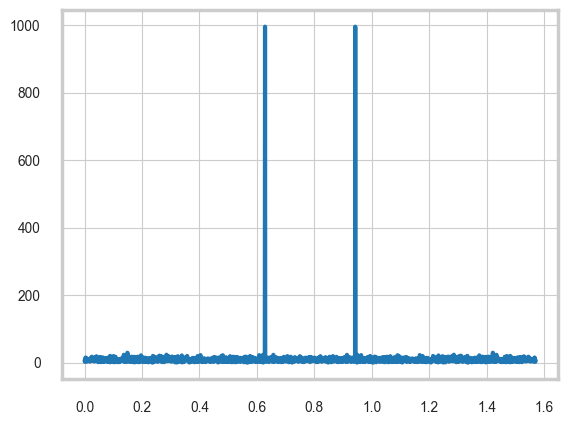

In [6]:
# Set the actual amplitude
theta = np.pi/5

theta1 = np.pi/5
theta2 = -theta1

depths = [i for i in range(2000)]
n_samples = [10 for d in depths]

R = estimate_signal(depths, n_samples, theta)

# R = [0.5*np.exp(1j*theta1*(2*d+1)) + 0.5*np.exp(1j*theta2*(2*d+1)) for d in depths]

fft = np.abs(np.fft.fft(R))

xaxis = [i*np.pi/(2*len(fft)) for i in range(len(fft))]

plt.plot(xaxis, fft)

In [7]:
# amax = np.argmax(fft[:len(fft)//2])
amax = np.argmax(fft)
print(f'theta: {theta1, theta2}')
print('peaks:', np.pi*(len(fft)-amax)/(2*len(fft)), np.pi*(amax)/(2*len(fft)))

theta: (0.6283185307179586, -0.6283185307179586)
peaks: 0.9424777960769379 0.6283185307179586


In [8]:
espirit = ESPIRIT()

theta_est, angle = espirit.estimate_theta_toeplitz(R)
print(f'angles: {angle/4}')
print(f'theta_est: {theta_est}')
print(f'theta: {theta}')
np.sum(np.abs(angle))/4

angles: [ 0.62863445 -0.62863445]
theta_est: 0.9421618807627496
theta: 0.6283185307179586


1.2572688920642938

## Get the real signal values on virtual locations 
One can do this using Chebyshev polynomials with the recurrence $\cos(nx) = 2\cos(x)\cos((n-1)x) - \cos((n-2)x)$

(0.9440485924037328, 0.6267477343911637, 0.6283185307179586)

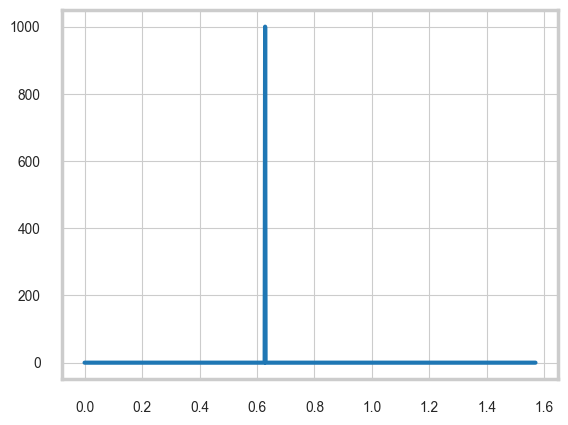

In [6]:
from scipy.special import chebyt

def get_cheb_vals(n_max, w):
    R = np.zeros(n_max)
    for n in range(n_max):
        R[n] = chebyt(2*n+1)(np.cos(w))
    return R

def get_cosine_values(n_max, w):
    R = np.zeros(n_max)
    for n in range(n_max):
        R[n] = 0.5*np.exp(1j*w*(2*n+1)) + 0.5*np.exp(-1j*w*(2*n+1))
        # R[n] = np.cos((2*n+1)*w)
    return R

# For reproducibility
# np.random.seed(8)

# theta = 0.5
# w = 2*theta
# a = np.cos(theta)

a = 0.75
theta = np.arccos(a)
theta = np.pi/5
w = 2*theta

d_max = 1000

depths = [i for i in range(d_max)]
# n_samples = [(d_max - d)//2 + 1 for d in depths]
n_samples = [10 for _ in depths]

R = estimate_signal(depths, n_samples, theta)
# R = get_cheb_vals(d_max, w)
# R = get_cosine_values(d_max, w)

fft = np.abs(np.fft.fft(R))

amax = np.argmax(fft[1:len(fft)//2])

xaxis = [i*np.pi/(2*len(fft)) for i in range(len(fft))]

plt.plot(xaxis, fft)

np.pi*(len(fft)-amax)/(2*len(fft)), np.pi*(amax)/(2*len(fft)), theta

In [7]:
espirit = ESPIRIT()

theta_est, angle = espirit.estimate_theta_toeplitz(R)
print(f'angles: {angle/2}')
print(f'theta_est: {2*theta_est}')
print(f'w:{w}')
np.sum(np.abs(angle))/4

angles: [-1.19610014 -1.26786697]
theta_est: 1.1961001421873891
w:1.2566370614359172


1.231983556722788

depths:[0, 1, 2, 4, 8, 16, 32, 64, 128, 256]
idx_vals:[1, 3, 5, 9, 17, 33, 65, 129, 257, 513]
{1: -0.36007100115722157, 3: 0.9999216204460302, 5: -0.5600102429905407, 9: 0.9997773581538408, 17: -0.5799602798444126, 33: 1.0000144321115827, 65: -0.640131085667697, 129: 0.9999791205448493, 257: -0.499797720633918, 513: 1.000023924161322}
512


(0.9694758579437253, 0.6013204688511713, 1.0471975511965976)

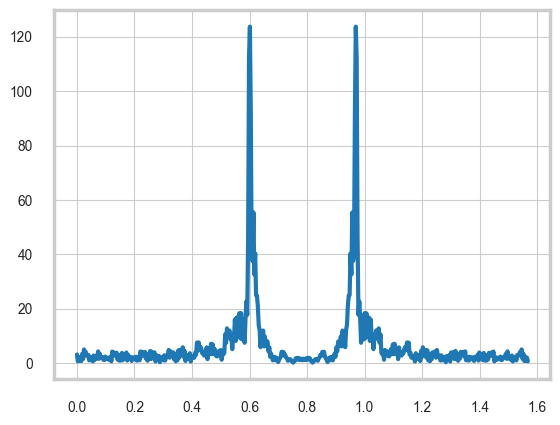

In [8]:
a = 0.1
theta = np.pi/3# np.arccos(a)
w = 2*theta


q = 8
depths = [0, 1]
for k in range(q):
    depths.append(2**(k+1))

idx_vals = []
for d in depths:
    idx_vals.append(2*d+1)

print(f'depths:{depths}')
print(f'idx_vals:{idx_vals}')


n_samples = [100 for _ in depths]

cos_values = {}
for i, depth in enumerate(depths):
    # noisy cos values
    p0 = P0(depth, theta)
    p1 = P1(depth, theta)
    p0_estimate = np.random.binomial(n_samples[i], p0)/n_samples[i]
    p1_estimate = np.random.binomial(n_samples[i], p1)/n_samples[i]
    cos_values[2*depth+1] = p0_estimate - p1_estimate
    cos_values[2*depth+1] = 2*p0_estimate - 1 + np.random.normal(0.0, 0.0001)
    # cos_values[2*depth+1] = 2*np.cos((2*depth+1)*theta)**2 - 1
    # cos_values[2*depth+1] = np.cos((2*depth+1)*w) + np.random.normal(0.0, 0.02)
    
print(cos_values)

def cheb_recursion(n):
    if n==0:
        return 1
    elif n in cos_values.keys():
        return cos_values[n]
    else:
        cos_values[n] = 2*cheb_recursion(1)*cheb_recursion(n-1)-cheb_recursion(n-2)
        return cos_values[n]
    
for d in range(idx_vals[-1]//2+1):
    cos_values[2*d+1] = cheb_recursion(2*d+1)
print(len(cos_values))

# R is the signal on physical and virtual locations
R = np.zeros(len(cos_values))
for d in range(idx_vals[-1]//2 + 1):
    R[d] = cos_values[2*d+1]

# R = [0.5*np.exp(1j*theta*(2*d+1)) + 0.5*np.exp(-1j*theta*(2*d+1)) for d in range(idx_vals[-1]//2 + 1)]

fft = np.abs(np.fft.fft(R))

amax = np.argmax(fft[:len(fft)//2])

xaxis = [i*np.pi/(2*len(fft)) for i in range(len(fft))]

plt.plot(xaxis, fft)

np.pi*(len(fft)-amax)/(2*len(fft)) , np.pi*(amax)/(2*len(fft)), theta

In [9]:
R = R[:len(R)//2]
len(R)

256

In [10]:
espirit = ESPIRIT()

theta_est, angle = espirit.estimate_theta_toeplitz(R)
print(f'angles: {angle}')
print(f'w: {w}')
print(f'theta_est: {theta_est}')
print(f'theta:{theta}')
np.sum(np.abs(angle))/4

angles: [ 2.41720381 -2.41720381]
w: 2.0943951023931953
theta_est: 0.9664953736318308
theta:1.0471975511965976


1.2086019063261315

In [41]:
theta = np.pi/5
w = 2*theta
depths = [d for d in range(4000)]
n_samples = [10 for d in depths]
complex_signal = estimate_signal(depths=depths, n_samples=n_samples, theta=theta)

espirit = ESPIRIT()

theta_est, angle = espirit.estimate_theta_toeplitz(complex_signal)
print(f'angles: {angle}')
print(f'w: {w}')
print(f'theta_est: {theta_est}')
print(f'theta:{theta}')

angles: [-2.51423504 -2.51474992]
w: 1.2566370614359172
theta_est: 0.6285587590036431
theta:0.6283185307179586


# Cumulant approach

In [110]:
theta = np.pi/5
w = 2*theta


logd = 6
depths = [0, 1]
for k in range(logd):
    depths.append(2**(k+1))

idx_vals = []
for d in depths:
    idx_vals.append(2*d+1)

print(f'depths:{depths}')
print(f'idx_vals:{idx_vals}')


n_samples = [100 for _ in depths]

difference_matrix = np.zeros((len(depths), len(depths)), dtype=int)
for r, rval in enumerate(depths):
    for c, cval in enumerate(depths):
        difference_matrix[r][c] = rval-cval
depths0 = difference_matrix.flatten(order='F')
depths0, idx = np.unique(depths0, return_index = True)
b = np.diff(depths0)
b = b[:len(b)//2]
try:
    start_idx = np.max(np.argwhere(b>1)) + 1
    idx = idx[start_idx:-start_idx]
except:
    pass
depths0, b, start_idx, np.argwhere(b>1)

depths:[0, 1, 2, 4, 8, 16, 32, 64]
idx_vals:[1, 3, 5, 9, 17, 33, 65, 129]


(array([-64, -63, -62, -60, -56, -48, -32, -31, -30, -28, -24, -16, -15,
        -14, -12,  -8,  -7,  -6,  -4,  -3,  -2,  -1,   0,   1,   2,   3,
          4,   6,   7,   8,  12,  14,  15,  16,  24,  28,  30,  31,  32,
         48,  56,  60,  62,  63,  64]),
 array([ 1,  1,  2,  4,  8, 16,  1,  1,  2,  4,  8,  1,  1,  2,  4,  1,  1,
         2,  1,  1,  1,  1]),
 18,
 array([[ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 8],
        [ 9],
        [10],
        [13],
        [14],
        [17]]))

In [86]:
complex_signal = estimate_signal(depths=depths, n_samples=n_samples, theta=theta)
complex_signal

array([ 0.30901699+9.51056516e-01j, -0.80901699-5.87785252e-01j,
        1.        -2.44929360e-16j,  0.30901699-9.51056516e-01j,
       -0.80901699+5.87785252e-01j, -0.80901699-5.87785252e-01j,
        1.        +3.92134568e-15j,  0.30901699-9.51056516e-01j])

In [87]:
'''
- lets compute the 2q-th order cumulants
- start with q=1, should give the regular covariance matrix of the observed signal R  = x x^T

'''
q = 1

cumulant_matrix = np.zeros((len(complex_signal)**q, len(complex_signal)**q), dtype=complex)
for i1 in range(len(complex_signal)):
    for i2 in range(len(complex_signal)):
        yi1 = complex_signal[i1] if i1<q else np.conj(complex_signal[i1])
        yi2 = complex_signal[i2] if i2<q else np.conj(complex_signal[i2])
        cumulant_matrix[i1][i2] = yi1*yi2
R = np.outer(complex_signal, np.conj(complex_signal)).flatten('F')[idx]
R


array([-0.80901699+5.87785252e-01j,  0.30901699-9.51056516e-01j,
        0.30901699+9.51056516e-01j, -0.80901699-5.87785252e-01j,
        1.        -9.21441096e-18j, -0.80901699+5.87785252e-01j,
        0.30901699-9.51056516e-01j,  0.30901699+9.51056516e-01j,
       -0.80901699-5.87785252e-01j])

In [74]:
R = cumulant_matrix.flatten('F')
R = R[len(R)//2:]

In [103]:
espirit = ESPIRIT()

theta_est, angle = espirit.estimate_theta_toeplitz(R)
print(f'angles: {angle/4}')
print(f'w: {w}')
print(f'theta_est: {theta_est}')
print(f'theta:{theta}')

angles: [-0.43762198 -0.78137277]
w: 1.2566370614359172
theta_est: 0.4376219795259574
theta:0.6283185307179586


In [10]:
a = np.array([1,2,3])
aa = np.outer(a,a)
aa

array([[1, 2, 3],
       [2, 4, 6],
       [3, 6, 9]])